<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Project%20codes/Assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1

Follow the classification example in Chapter 6 in Hands-On Generative AI with Transformers and Diffusion Models and extend it in the following ways:
1. Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.
2. Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.
3. Compare the test set performance of the two fine-tuned models.
4. Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.

## Setup

Loading all the needed functions, libraries and logging in to the services (HF and wandb).

In [ ]:
# Installing necessary packages
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
# Libraries
import evaluate
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch

# Functions
from datasets import load_dataset
from google.colab import userdata
from huggingface_hub import login as login_hf
from sklearn.metrics import ConfusionMatrixDisplay
from torch.nn.functional import cross_entropy
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer, TrainingArguments
from wandb import login as login_wandb

In [ ]:
# Logging in to Huggingface and wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
login_hf(os.environ['HF_TOKEN'])
login_wandb(key = os.environ['WANDB_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simonmellergaard (simonmellergaard-aarhus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Setting up the device (GPU). Code is taken from the genaibook-module.
def get_device(cuda_ordinal=None):
    if torch.cuda.is_available():
        return torch.device("cuda", cuda_ordinal)
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()

## 1 Error based analysis DistilBert

> *Perform an error analysis based on the fine-tuned DestilBert model on the AG News dataset.*

The model is being loaded with the pipeline argument. This code will fetch the model from the Hugging Face repository where the model fine-tuned DistilBert model is found. The name for the model is somewhy "classifier chapter 4", despite the model is created in chapter 6. The model is extracted from the pipeline to make the predictions.

In [ ]:
# Use a pipeline as a high-level help
pipe = pipeline(
    "text-classification",
    model="genaibook/classifier-chapter4",
    device="cuda",
)
# Transforming the pipe to a model
model = pipe.model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda


The model is now loaded. The foward_pass_with_label is used to compute the loss for the predictions.

In [ ]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

The ag_news dataset is being loaded, tokenized and encoded to make the model ready to make predictions.

In [ ]:
ag_news = load_dataset("ag_news")
checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
ag_news_encoded = ag_news.map(tokenize, batched=True, batch_size=None)
# Convert our dataset back to PyTorch tensors
ag_news_encoded.set_format("torch",
                            columns=['text', 'label', 'input_ids', 'attention_mask'])

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

The device is set to the GPU using the below funciton. This is used for making predictions.

In [ ]:
# Compute loss values
ag_news_encoded["test"] = ag_news_encoded["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

The predictions and the losses has now been made. The dataset is finally transformed to a pandas dataframe to inspect the data.

In [ ]:
def label_int2str(row):
    return ag_news["test"].features["label"].int2str(row)

ag_news_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = ag_news_encoded["test"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

The error-based analysis can now begin. First, the most wrongly predicted labels are identified:

In [ ]:
pd.set_option('display.max_colwidth', None)
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1269,"Philippines mourns dead in Russian school siege The Philippines Saturday expressed quot;deepest sympathy quot; to the families of the dead in the Russian school siege on Friday, in which 322 people were killed when Russian troops stormed",Sci/Tech,World,6.639397
1840,"Icing call Out of money, out of patience, out of time, and for the foreseeable future, out of business.",Sports,Sci/Tech,6.400067
912,Bryant Makes First Appearance at Trial (AP) AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday as attorneys in the case who spent the weekend poring over questionnaires prepared to question potential jurors individually.,Sci/Tech,Sports,6.260278
2833,"Man arrested for fatally stabbing elderly parents SAITAMA -- A middle-aged man who fatally stabbed his parents has been arrested, police said. Hideo Nakajima, an unemployed man from Soka, Saitama Prefecture, apparently called police shortly before 8 pm, Wednesday.",Sci/Tech,World,6.246093
6185,Special to ESPN.com It #39;s the age old question: quot;What do you give to the man who #39;s been everything? quot;. Only time will tell whether Phil Knight #39;s retirement will be as long-lived as so many players he paid to endorse Nike.,Business,Sports,6.245818
5841,"INSIDE INFO: Man Utd shares drop MAN UNITED #39;S share price has fallen by just over 2.5, less than expected after the resignation of Malcolm Glazer #39;s bankers JP Morgan.",Sports,Business,6.155990
1317,Florida deaths blamed on Hurricane Frances State and local officials Tuesday said nine people have died in Florida because of Hurricane Frances. The following describes those deaths: - A 15-year-old grandson and a former son,Sports,World,6.115888
2126,Bush Scraps Most U.S. Sanctions on Libya (Reuters) Reuters - President Bush on Monday formally\ended the U.S. trade embargo on Libya to reward it for giving\up weapons of mass destruction but left in place U.S.\terrorism-related sanctions.,Sci/Tech,World,6.091242
1197,"World briefs LONDON - A man wielding a machete and a knife attacked two security guards at the building housing the headquarters of the British domestic intelligence service MI5 on Friday, police said.",Business,World,5.897985
2579,SC to hear Zee petition tommorrow Five judges of the top court will hear a petition filed by Zee Telefilms on Tuesday. A three-judge panel of the Supreme Court said a five-judge bench would hear the dispute that threatens the rights of India #39;s,Sports,World,5.844354


Looking at the most wrongly predicted labels, it is clear to see that some of the texts seem to be ambiguous. This coul be label 5841, which is considering th Manchester United stock. The correct label is sports, but it could be argued that this is is a business theme. Other texts seems to be wrongly labeled, such as 2833, which is about a man stabbing, but is labeled as sci/tech. Some of this ambiguous data could therefore be better labeled, and ambiguous texts could be removed. also some special character #39; is being used, which might do something bad to the model.

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
7058,"Blast Targets Baghdad Checkpoint Near Allawi HQ (Reuters) Reuters - A car bomb that exploded near the\headquarters of Iraqi Prime Minister Iyad Allawi's party in\western Baghdad on Monday targeted a police checkpoint at the\entrance to the road leading to the building, witnesses said.",World,World,0.004360
6948,"Three Iraqis Killed in Bomb Attack on U.S. Troops SAMARRA, Iraq (Reuters) - Three Iraqis were killed on Wednesday when a suicide car bomber attacked a U.S. convoy in the northern city of Samarra, a local police official said.",World,World,0.004377
5412,US troops reach centre of Fallujah as 48 killed in Baquba and &lt;b&gt;...&lt;/b&gt; FALLUJAH: Iraqi Prime Minister Ayad Allawi on Tuesday imposed a night curfew in Baghdad as US troops with crack Iraqi soldiers surged into the heart of Fallujah in a hail of explosions and gunfire on the second day of the largest operation in Iraq since,World,World,0.004393
1263,"Blast kills seven US Marines in Iraq A massive car bomb exploded on the outskirts of the Iraqi city of Fallujah, killing seven United States Marines and wounding several others, a US military official said.",World,World,0.004413
6632,"Car Bomb North of Baghdad Kills 7, Wounds 19 (Reuters) Reuters - A car bomb exploded near a U.S.\military patrol in the town of Baiji, north of Baghdad, on\Tuesday, killing at least seven Iraqis and wounding 20 people,\including two U.S. soldiers, doctors and the military said.",World,World,0.004414
4353,"Roadside Bomb Injures Six GIs in Iraq (AP) AP - A roadside bomb exploded near an American military patrol in Baghdad Saturday, injuring six soldiers, the U.S. command said.",World,World,0.004418
393,"U.S. Plane Attacks Najaf Rebels as Tanks Near Shrine NAJAF, Iraq (Reuters) - A U.S. AC-130 gunship attacked Shi'ite militia positions in the holy Iraqi city of Najaf early on Monday after tanks reinforced the siege of a shrine at the center of a nearly three-week insurgency.",World,World,0.004430
7368,"Kidnapped Turk Killed in Afghanistan -- Witness A Turkish engineer abducted by a militant gang in eastern Afghanistan was found dead on Wednesday, a witness who saw the body being carried down from a mountainside told Reuters.",World,World,0.004442
4598,Israeli Officer Arrested Over Killing of Gaza Girl (Reuters) Reuters - Israeli military police on Tuesday\arrested a commander accused by comrades of riddling the body\of a Palestinian schoolgirl with bullets after fellow soldiers\killed her.,World,World,0.004445
2140,"Scores of Iraqis die in 3 days of attacks US troops fought a gunbattle with insurgents along a busy street in Baghdad today, sending passers-by scurrying for cover, witnesses said, Five US troops were reported killed in separate clashes in a volatile western province as",World,World,0.004447


All the instances with low loss has been classifid as world, which could indicate that the model is memorizing something or looking for somethings that triggers that this label is predicted.

## 2 Fine-tuning ModernBert

> *Fine-tune a ModernBert model (answerdotai/ModernBERT-base) in a similar fashion as DestilBert was fine-tuned in the chapter.*

This analysis will make a fine-tuned version of the [ModernBERT model](https://huggingface.co/answerdotai/ModernBERT-base).

The first thing to do is to load the dataset and make it ready for the model to train on.

In [ ]:
# Loading the dataset
raw_datasets = load_dataset("ag_news")
raw_train_dataset = raw_datasets["train"]

# Creating a tokenizer function based on the ModernBERT model
checkpoint = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
def tokenize_function(batch):
    return tokenizer(
        batch["text"], truncation=True, padding=True, return_tensors="pt"
    )

# Tokenizingi the dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

The compute metrics function is used from the model before.

In [ ]:
# Loading the base model and initialize a classification head.
num_labels = 4
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, num_labels=num_labels
).to(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The training arguments for the model are defined, using 2 epochs and a batch size of 32.

In [ ]:
batch_size = 32
training_args = TrainingArguments(
    "classifier-modernbert-agnews",
    push_to_hub=True,
    num_train_epochs=2,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size
)

Defining a compute metrics function that computes the f1-score and the accuracy during training to monitor the progress.

In [ ]:
f1_score = evaluate.load("f1")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

For training, only 10,000 examples are used to make the model train faster. This is a the cost of potentially missing out on more training data, which would have given a better model.

In [ ]:
# Shuffle the dataset and pick 10,000 examples for training
shuffled_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_split = shuffled_dataset.select(range(10000))

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_split,
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
)

/tmp/ipython-input-929705096.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


The model is now ready for training, and can be trained:

In [ ]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


W0911 12:40:32.204000 1200 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.248691,0.912632,0.912548
2,0.268800,0.249549,0.923947,0.923948


TrainOutput(global_step=626, training_loss=0.24026718535743202, metrics={'train_runtime': 1811.4288, 'train_samples_per_second': 11.041, 'train_steps_per_second': 0.346, 'total_flos': 4393473122366208.0, 'train_loss': 0.24026718535743202, 'epoch': 2.0})

The model is pused to Hugging Face.

In [ ]:
trainer.push_to_hub()

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...modernbert-agnews/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...modernbert-agnews/model.safetensors:   6%|5         | 33.5MB /  598MB            

  ...ents.1757594422.0adab256b85c.1200.0: 100%|##########| 7.09kB / 7.09kB            

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/classifier-modernbert-agnews/commit/fca6c0e2bc7850cb042fb8b395fe4d5c58c6f766', commit_message='End of training', commit_description='', oid='fca6c0e2bc7850cb042fb8b395fe4d5c58c6f766', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/classifier-modernbert-agnews', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/classifier-modernbert-agnews'), pr_revision=None, pr_num=None)

The model is now on the hub, and can be fetched with the pipeline funciton

In [ ]:
# Loading the model from the hub with a pipeline
pipe_modernbert = pipeline(
    "text-classification",
    model="simon-mellergaard/classifier-modernbert-agnews",
    device="cuda",
)

Device set to use cuda


The model can be tested on the test set to check the performance, using a confusion matrix and other performance measures. This is done in the following section.

## 3 Comparison of performance

> *Compare the test set performance of the two fine-tuned models.*



To calculate the test set performance of the two models, the accuracy and the F1-scores can be calculated. These are first calculated by loading the metrics from the evaluate package.

In [ ]:
# Compute accuracy and F1 Score
f1_score = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

Making predictions for the ModernBERT model:

In [ ]:
# Making predictions
model_preds_modernbert = pipe_modernbert.predict(list(tokenized_datasets["test"]["text"]))
# Get the dataset labels
references_modernbert = tokenized_datasets["test"]["label"]
# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels_modernbert = [label_to_id[pred["label"]] for pred in model_preds_modernbert]

accuracy_modernbert = accuracy.compute(references=references_modernbert, predictions=pred_labels_modernbert)["accuracy"]
f1_modernbert = f1_score.compute(references=references_modernbert, predictions=pred_labels_modernbert, average="weighted")["f1"]

The same can be done with the DistilBERT model. This requires that the dataset is first tokenized to fit the distilBERT dataset.

In [ ]:
checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_datasets_distil = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
# Making predictions
model_preds_distilbert = pipe.predict(list(tokenized_datasets_distil["test"]["text"]))
# Get the dataset labels
references_distilbert = tokenized_datasets_distil["test"]["label"]
# Get the list of label names
label_names = raw_train_dataset.features["label"].names

# Convert predicted labels to ids
label_to_id = {name: i for i, name in enumerate(label_names)}
pred_labels_distilbert = [label_to_id[pred["label"]] for pred in model_preds_distilbert]

accuracy_distilbert = accuracy.compute(references=references_distilbert, predictions=pred_labels_distilbert)["accuracy"]
f1_distilbert = f1_score.compute(references=references_distilbert, predictions=pred_labels_distilbert, average="weighted")["f1"]

Comparing the results using a dataframe:

In [ ]:
results = {
    "Model": ["fine-tuned DistilBERT", "fine-tuned ModernBERT"],
    "Accuracy": [accuracy_distilbert, accuracy_modernbert],
    "F1 Score": [f1_distilbert, f1_modernbert],
}

df_results = pd.DataFrame(results)
display(df_results)

,Model,Accuracy,F1 Score
0,fine-tuned DistilBERT,0.916316,0.916267
1,fine-tuned ModernBERT,0.923947,0.923948


The model shows that both the accuracy and the F1-score of the ModernBERT is better than the DistilBert. This should not be surprising, as the base model of ModernBERT should be superior. Looking at the confusion matrixes:

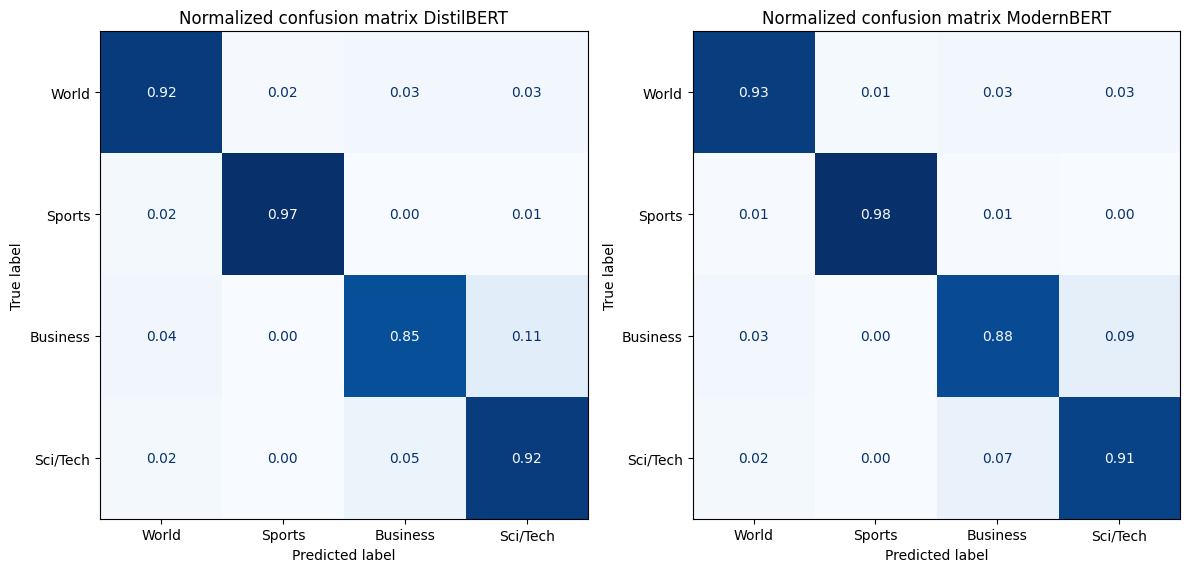

In [ ]:
confusion_matrix = evaluate.load("confusion_matrix")
# Calculate confusion matrix for DistilBERT
cm_distilbert = confusion_matrix.compute(
    references=references_distilbert, predictions=pred_labels_distilbert, normalize="true"
)["confusion_matrix"]

# Calculate confusion matrix for ModernBERT
cm_modernbert = confusion_matrix.compute(
    references=references_modernbert, predictions=pred_labels_modernbert, normalize="true"
)["confusion_matrix"]

# Plot the confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_distilbert = ConfusionMatrixDisplay(confusion_matrix=cm_distilbert, display_labels=label_names)
disp_distilbert.plot(cmap="Blues", values_format=".2f", ax=axes[0], colorbar=False)
axes[0].set_title("Normalized confusion matrix DistilBERT")

disp_modernbert = ConfusionMatrixDisplay(confusion_matrix=cm_modernbert, display_labels=label_names)
disp_modernbert.plot(cmap="Blues", values_format=".2f", ax=axes[1], colorbar=False)
axes[1].set_title("Normalized confusion matrix ModernBERT")

plt.tight_layout()
plt.show()

Both models look very similar in terms of predictive power, as they have similar accuracies across the different categories. However it seems that ModernBERT is superior at predicting all categories compared to DistilBERT.

Both models seems to be especially good at predicting sports, and seems to confuse business and sci/tech more often. The world class is also not predicted correctly as often as sports, but is more spread out across the other labels in terms of wrongly predicted labels.

## 4 Error based analysis ModernBert

> *Perform an error analysis on the AG News based on the fine-tuned ModernBert and compare it to DestilBert.*



The error-based analysis on the fine-tuned ModernBERT classifier is done in the same fashion as the DistilBert model. Here a new encoded dataset is created to make different predictions than the distil bert dataset. Note that the tokenize function for ModernBERT is already loaded.

In [ ]:
# Transforming the pipe to a model
model = pipe_modernbert.model.eval()

ag_news_encoded_2 = ag_news.map(tokenize, batched=True, batch_size=None)
# Convert our dataset back to PyTorch tensors
ag_news_encoded_2.set_format("torch",
                            columns=['text', 'label', 'input_ids', 'attention_mask'])

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

The loss value is computed.

In [ ]:
# Compute loss values
ag_news_encoded_2["test"] = ag_news_encoded_2["test"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
ag_news_encoded_2.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test_2 = ag_news_encoded_2["test"][:][cols]
df_test_2["label"] = df_test_2["label"].apply(label_int2str)
df_test_2["predicted_label"] = (df_test_2["predicted_label"]
                              .apply(label_int2str))

Looking at the most wrongly predicted labels

In [ ]:
pd.set_option('display.max_colwidth', None)
df_test_2.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1197,"World briefs LONDON - A man wielding a machete and a knife attacked two security guards at the building housing the headquarters of the British domestic intelligence service MI5 on Friday, police said.",Business,World,14.847056
1269,"Philippines mourns dead in Russian school siege The Philippines Saturday expressed quot;deepest sympathy quot; to the families of the dead in the Russian school siege on Friday, in which 322 people were killed when Russian troops stormed",Sci/Tech,World,14.121422
2833,"Man arrested for fatally stabbing elderly parents SAITAMA -- A middle-aged man who fatally stabbed his parents has been arrested, police said. Hideo Nakajima, an unemployed man from Soka, Saitama Prefecture, apparently called police shortly before 8 pm, Wednesday.",Sci/Tech,World,10.462735
4300,"City Series-ly wounded With the Yanks out of the World Series, the city #39;s economy loses out on at least \$40 million, according to studies by the controller #39;s office and other city agencies.",Sports,Business,10.258419
912,Bryant Makes First Appearance at Trial (AP) AP - NBA star Kobe Bryant arrived at his sexual assault trial Monday as attorneys in the case who spent the weekend poring over questionnaires prepared to question potential jurors individually.,Sci/Tech,Sports,10.124939
7228,Indonesian diplomats asked to help improve RI #39;s bad image JAKARTA (Antara): President Susilo Yudhoyono asked Indonesian diplomats on Monday to help the government improve Indonesia #39;s bad image.,Business,World,9.669601
5740,"Dow Jones Agrees to Buy MarketWatch in \$519 Million Deal Dow Jones Company, the publisher of The Wall Street Journal, has agreed to buy MarketWatch, the parent company of the financial news Web site CBS MarketWatch, for approximately \$519 million, the companies said today.",World,Business,9.641088
5841,"INSIDE INFO: Man Utd shares drop MAN UNITED #39;S share price has fallen by just over 2.5, less than expected after the resignation of Malcolm Glazer #39;s bankers JP Morgan.",Sports,Business,9.332381
1364,"Hyundai signs deal for China truck plant Hyundai Motor Co. said yesterday that it has signed an agreement with a Chinese company, Jianghuai Automobile Corp., to build a commercial vehicle and engine plant in China #39;s Anhui province.",Sci/Tech,Business,9.212212
4097,"Greenspan: Debt, home prices not dangerous The record level of debt carried by American households and soaring home prices do not appear to represent serious threats to the US economy, Federal Reserve Chairman Alan Greenspan said Tuesday.",Sci/Tech,Business,9.030437


Mostly guessin gbusiness and world, where the actual labels are different.

Looking at the most correctly predicted labels

In [ ]:
df_test_2.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1445,"Jakarta Embassy Blast Kills 9, Hurts 173 JAKARTA, Indonesia - Suspected Muslim militants detonated a car bomb Thursday outside the Australian Embassy in Jakarta, killing nine people and wounding 173 in a bloody strike at a key U.S. ally in the war in Iraq...",World,World,-0.000000e+00
3528,"Two Car Bombs Kill 10 Iraqis in Baghdad BAGHDAD, Iraq - Two car bombs shook the capital in quick succession Sunday, killing at least 10 Iraqis and wounding 16, police and hospital officials said. One American soldier was hurt...",World,World,-0.000000e+00
2901,"80 Killed in U.S. Offensive in Iraq SAMARRA, Iraq - U.S. and Iraqi forces launched a major assault Friday to regain control of the insurgent stronghold of Samarra, and hospital officials said at least 80 people were killed and 100 wounded...",World,World,-0.000000e+00
7029,"Six Iraqi national guards, 10 civilians wounded in Mosul attacks MOSUL, Iraq, Dec 9 (AFP) - Six Iraqi national guardsmen and 10 civilians were wounded in two bomb attacks in the northern city of Mosul on Thursday, police said.",World,World,1.192093e-07
2802,"Britain extends citizenship rights to Gurkha soldiers (AFP) AFP - Britain has extended full citizenship rights to Gurkha soldiers from Nepal who serve in the British armed forces, Prime Minister Tony Blair has said.",World,World,1.192093e-07
2840,"Footage Shows 10 New Hostages in Iraq BAGHDAD, Iraq - The Arab news network Al-Jazeera showed video Thursday of 10 new hostages seized in Iraq by militants. Al-Jazeera said the 10 - six Iraqis, two Lebanese and two Indonesian women - were taken by The Islamic Army in Iraq...",World,World,1.192093e-07
2118,"Attackers shoot, burn villagers in east Congo, killing 14, UN says (Canadian Press) Canadian Press - KINSHASA, Congo (AP) - Attackers overran a sleeping village in east Congo's lawless Ituri province Monday and slaughtered 14 residents, including seven children who were burned alive, a UN spokeswoman said.",World,World,1.192093e-07
2108,"Car Bomb Kills Three in Mosul (AP) AP - A car bomb exploded in the northern Iraq city of Mosul on Monday, killing three people, hospital police said.",World,World,1.192093e-07
1834,"Gunmen Seize Three Britons in Baghdad (Reuters) Reuters - Three British nationals, believed to be\civilians, were snatched by gunmen from a house in central\Baghdad early on Thursday, Iraq's Interior Ministry said.",World,World,1.192093e-07
4378,"Taliban suicide bomber kills girl, wounds 6 others KABUL - A man with six grenades strapped to his body killed himself and a 12-year-old girl on a busy street in Kabul Saturday, police said.",World,World,1.192093e-07


Everything is something about kills, and somebody getting killed. All the predictions are world, and there is basically a loss on 0. Also in general civilians are mentionnend and other things regarding violent actions.